# Yuki Yoshiyasu

**Disclamer**

ChatGPT has been used just for generating comments on the code.

In [1]:
#All essential imports to run the assignment
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from pyproj import Geod
from itertools import combinations
from matplotlib import pyplot as plt

## 1. Loading in relevant files to produce a "world" map 

In [2]:
#Reading in relevant files (circuits, constructors, motorsport_valley, world)
circuits = gpd.read_file('https://github.com/grantdick/INFO204/raw/main/circuits.zip')
constructors = gpd.read_file('https://github.com/grantdick/INFO204/raw/main/constructors.zip')
motorsport_valley = gpd.read_file('https://github.com/grantdick/INFO204/raw/main/motorsport_valley.zip')
world = gpd.read_file("https://github.com/grantdick/INFO204/raw/main/world-administrative-boundaries.zip")

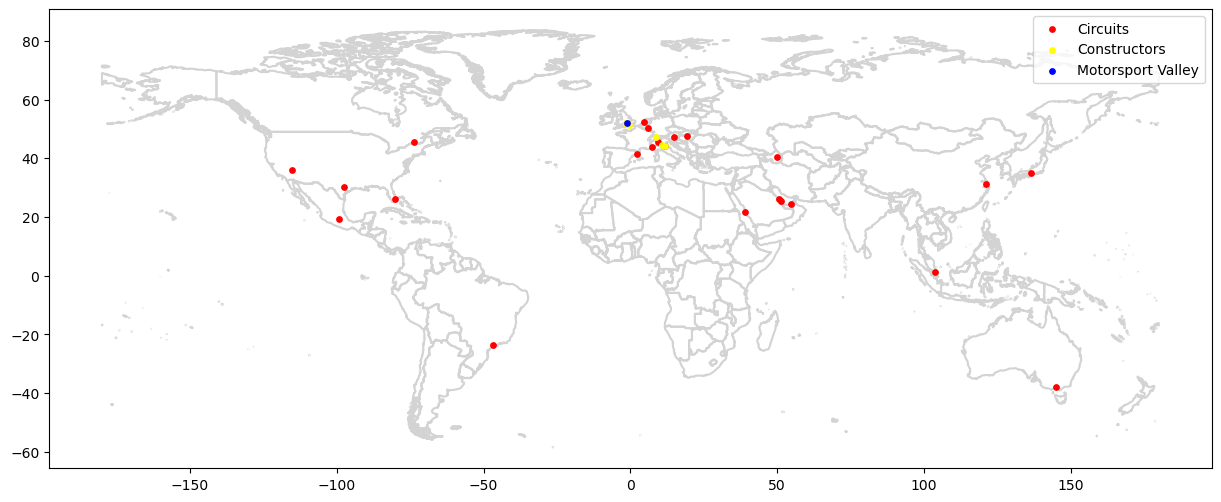

In [3]:
# Create a new figure with a specified size (15x10 inches)
fig = plt.figure(figsize=(15, 10))

# Create an axes object for plotting within the figure
ax = plt.axes()

# Plot the world boundary as a background layer in light grey
base = world.boundary.plot(ax=ax, color="lightgrey", zorder=0, aspect="equal")

# Plot the "circuits" data on top of the world map in red
# Markers are used with a size of 15, Zorder specifies the layer order, higher values are plotted on top
# Aspect ensures that the aspect ratio is equal,Label is provided for the legend
circuits.plot(ax=base, color="red", markersize=15, zorder=1, aspect="equal", label="Circuits")

# Plot the "constructors" data on top of the world map in yellow
# Similar settings as above
constructors.plot(ax=base, color="yellow", markersize=15, zorder=1, aspect="equal", label="Constructors")

# Plot the "motorsport_valley" data on top of the world map in blue
# Similar settings as above
motorsport_valley.plot(ax=base, color="blue", markersize=15, zorder=1, aspect="equal", label="Motorsport Valley")

# Add a legend to the plot based on the labels provided earlier
plt.legend()

# Display the final plot
plt.show()


## 2. Computing the worst-case costs of the calendar

In [4]:
#The plot_path function plots a path on a map, given a list of node indices representing the order of nodes in the path, 
#with options to customize node and path appearance, and the inclusion of directional arrows if desired.
def plot_path(loc, path, x='lng', y='lat', arrows=True, node_colour='#ce2227', tour_colour='#f9c013', ax=None):
    V = loc
    E = loc.loc[np.append(path, path[0])]

    if ax is None:
        fig = plt.figure()
        ax = plt.axes()
        
    ax.plot(V[x], V[y], '.', ms=7.5, c=node_colour, zorder=1)
    if arrows:
        x, y = E[x].to_numpy(), E[y].to_numpy()
        ox, oy = x[:-1], y[:-1]
        dx, dy = x[1:] - x[:-1], y[1:] - y[:-1]
        ax.quiver(ox, oy, dx, dy, scale_units='xy', angles='xy', scale=1, zorder=0, headlength=3, headwidth=2, headaxislength=2.5, width=0.0025, color=tour_colour)
    else:
        ax.plot(E[x], E[y], c=tour_colour, lw=2, zorder=0)

In [5]:
#The compute_cost_matrix function calculates a square matrix that represents the distances 
#between various locations using their geographical coordinates (longitude and latitude), 
#which is essential for solving optimization problems like the Traveling Salesman Problem (TSP).
def compute_cost_matrix(loc, lng="lng", lat = "lat"):
    g = Geod(ellps="WGS84")
    coords = list(zip(loc[lng].values, loc[lat].values))

    C = np.zeros(shape=(len(coords), len(coords)))
    for i, j in combinations(range(len(coords)),2):
        f,t= coords[i],coords[j]
        _,_,dist = g.inv(f[0],f[1],t[0],t[1])
        C[i,j]=C[j,i]=dist

    return C

In [6]:
#This tour_cost fucntion computes the total cost of a tour by summing the distances between 
#consecutive locations based on a given cost matrix.
def tour_cost(C, tour):
    N = len(tour)
    total_cost = 0

    for i in range(N):
       
        total_cost += C[tour[i], tour[(i + 1) % N]]

    return total_cost

250678.26727508422
If traveling directly from their factories to circuits and then back home again, on average each team would travel approximately 250,000 kilometers for the season.

 Average travel distance for each team plotted as a bar graph


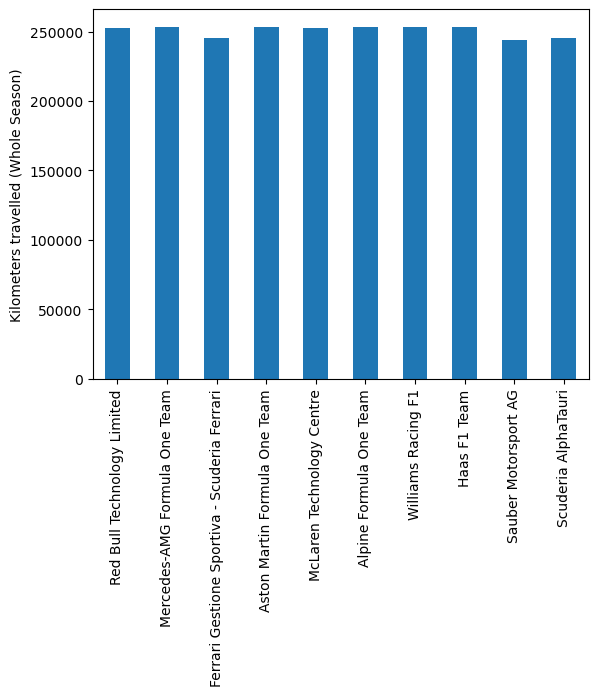

In [7]:
# Concatenate the "constructors" and "circuits" DataFrames and reset the index
loc = pd.concat([constructors, circuits]).reset_index(drop=True)

# Extract latitude and longitude coordinates from the 'geometry' column
loc["lat"] = loc["geometry"].y
loc["lng"] = loc["geometry"].x

# Compute the cost matrix 'C' representing distances between locations
C = compute_cost_matrix(loc)

# Create a DataFrame 'constructor_travel_costs' with distances between constructors and circuits
constructor_travel_costs = pd.DataFrame(C, columns=loc.Name, index=loc.Name)

# Calculate the total travel costs for each constructor by summing the distances to all circuits
# Only considering the first 10 constructors and all circuits, then converting to kilometers
constructor_travel_costs = 2 * constructor_travel_costs.iloc[:10, 10:].sum(axis=1) / 1000

# Calculate the average travel distance for all constructors
average_dist = constructor_travel_costs.mean()

# Print the average travel distance and a related message
print(average_dist)
print(f"If traveling directly from their factories to circuits and then back home again, on average each team would travel approximately 250,000 kilometers for the season.")
print("\n","Average travel distance for each team plotted as a bar graph")
# Plot the travel costs as a bar chart
constructor_travel_costs.plot(kind="bar")
plt.xlabel(None)
plt.ylabel("Kilometers travelled (Whole Season)")
plt.show()



## 3. Loading in the location of "Motorsport Valley"

In [8]:
# Concatenate the "motorsport_valley" and "circuits" DataFrames and reset the index
loc = pd.concat([motorsport_valley, circuits]).reset_index(drop=True)

# Extract latitude and longitude coordinates from the 'geometry' column
loc["lat"] = loc["geometry"].y
loc["lng"] = loc["geometry"].x

# Print the resulting DataFrame 'loc'
print(loc)

# Compute the cost matrix 'C' representing distances between locations
C = compute_cost_matrix(loc)

# Create a DataFrame showing the cost matrix 'C' with columns and indices labeled by location names
pd.DataFrame(C, columns=loc.Name, index=loc.Name)


                                   Name  \
0                     Motorsport Valley   
1         Bahrain International Circuit   
2       Jeddah Formula 1 Street Circuit   
3         Albert Park Formula 1 Circuit   
4                        Suzuka Circuit   
5   Shanghai Audi International Circuit   
6         Miami International Autodrome   
7         Autodromo Enzo e Dino Ferrari   
8           Monaco Grand Prix de Monaco   
9             Circuit Gilles Villeneuve   
10       Circuit de Barcelona-Catalunya   
11                        Red Bull Ring   
12                  Silverstone Circuit   
13                          Hungaroring   
14      Spa Francorchamps Grand Prix F1   
15             CM.com Circuit Zandvoort   
16            Autodromo Nazionale Monza   
17                    Baku City Circuit   
18            Marina Bay Street Circuit   
19              Circuit of the Americas   
20         Autodromo Hermanos Rodriguez   
21           Autódromo José Carlos Pace   
22         

Name,Motorsport Valley,Bahrain International Circuit,Jeddah Formula 1 Street Circuit,Albert Park Formula 1 Circuit,Suzuka Circuit,Shanghai Audi International Circuit,Miami International Autodrome,Autodromo Enzo e Dino Ferrari,Monaco Grand Prix de Monaco,Circuit Gilles Villeneuve,...,CM.com Circuit Zandvoort,Autodromo Nazionale Monza,Baku City Circuit,Marina Bay Street Circuit,Circuit of the Americas,Autodromo Hermanos Rodriguez,Autódromo José Carlos Pace,Las Vegas F1 Circuit,Lusail International Circuit,Yas Marina Circuit
Name,,,,,,,,,,,,,,,,,,,,,
Motorsport Valley,0.000000e+00,5.162529e+06,4.808634e+06,1.695356e+07,9.552041e+06,9.215276e+06,7.054935e+06,1.264286e+06,1.104008e+06,5.157861e+06,...,3.890167e+05,1.029184e+06,4.045644e+06,1.091625e+07,7.856055e+06,8.866718e+06,9.476811e+06,8.353113e+06,5.270345e+06,5.566945e+06
Bahrain International Circuit,5.162529e+06,0.000000e+00,1.259466e+06,1.210594e+07,8.069229e+06,6.817499e+06,1.220450e+07,4.022761e+06,4.338154e+06,1.027915e+07,...,4.809650e+06,4.247493e+06,1.591728e+06,6.328209e+06,1.292879e+07,1.400744e+07,1.181263e+07,1.296434e+07,1.118667e+05,4.473021e+05
Jeddah Formula 1 Street Circuit,4.808634e+06,1.259466e+06,0.000000e+00,1.281570e+07,9.308775e+06,8.075680e+06,1.162280e+07,3.558563e+06,3.810744e+06,9.946594e+06,...,4.514441e+06,3.796974e+06,2.313078e+06,7.358891e+06,1.265133e+07,1.359189e+07,1.055365e+07,1.306665e+07,1.330167e+06,1.618466e+06
Albert Park Formula 1 Circuit,1.695356e+07,1.210594e+07,1.281570e+07,0.000000e+00,8.095496e+06,8.047530e+06,1.559692e+07,1.608341e+07,1.642043e+07,1.673781e+07,...,1.656689e+07,1.628505e+07,1.297673e+07,6.049393e+06,1.428278e+07,1.356402e+07,1.308304e+07,1.312125e+07,1.199409e+07,1.166765e+07
Suzuka Circuit,9.552041e+06,8.069229e+06,9.308775e+06,8.095496e+06,0.000000e+00,1.480161e+06,1.224538e+07,9.620544e+06,9.897407e+06,1.060773e+07,...,9.279929e+06,9.642386e+06,7.359223e+06,5.027304e+06,1.085011e+07,1.161665e+07,1.873096e+07,9.206374e+06,8.018988e+06,7.801349e+06
Shanghai Audi International Circuit,9.215276e+06,6.817499e+06,8.075680e+06,8.047530e+06,1.480161e+06,0.000000e+00,1.326868e+07,9.006222e+06,9.322392e+06,1.136574e+07,...,8.887703e+06,9.077991e+06,6.350580e+06,3.794720e+06,1.206440e+07,1.293893e+07,1.855975e+07,1.051023e+07,6.754392e+06,6.505410e+06
Miami International Autodrome,7.054935e+06,1.220450e+07,1.162280e+07,1.559692e+07,1.224538e+07,1.326868e+07,0.000000e+00,8.187952e+06,7.885359e+06,2.249771e+06,...,7.421684e+06,7.959729e+06,1.103614e+07,1.695769e+07,1.770922e+06,2.066800e+06,6.575115e+06,3.497591e+06,1.231414e+07,1.261868e+07
Autodromo Enzo e Dino Ferrari,1.264286e+06,4.022761e+06,3.558563e+06,1.608341e+07,9.620544e+06,9.006222e+06,8.187952e+06,0.000000e+00,3.507680e+05,6.390093e+06,...,1.039363e+06,2.384548e+05,3.143875e+06,1.008213e+07,9.094202e+06,1.007073e+07,9.592523e+06,9.614597e+06,4.133541e+06,4.448726e+06
Monaco Grand Prix de Monaco,1.104008e+06,4.338154e+06,3.810744e+06,1.642043e+07,9.897407e+06,9.322392e+06,7.885359e+06,3.507680e+05,0.000000e+00,6.139000e+06,...,9.857856e+05,2.559951e+05,3.493775e+06,1.043022e+07,8.843234e+06,9.793964e+06,9.285270e+06,9.436209e+06,4.449456e+06,4.768838e+06


## 4. Produces a plot of the proposed calendar tour starting from Motorsport Valley with cost of tour

In [9]:
# Create an array 'tour' containing indices for all locations in 'loc'
tour = np.arange(len(loc))

# Calculate the current total cost of the tour and convert it to kilometers
current_cost = tour_cost(C, tour) / 1000

# Print the 'tour' array and the current total cost in kilometers
print(tour, current_cost)

# Determine the total number of locations in 'loc' and store it in variable 'N'
N = len(loc)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] 132181.98056424374


#### The cost of the tour using the proposed calendar is 132181.98056424374 which is approximately 132,000km.

<Axes: >

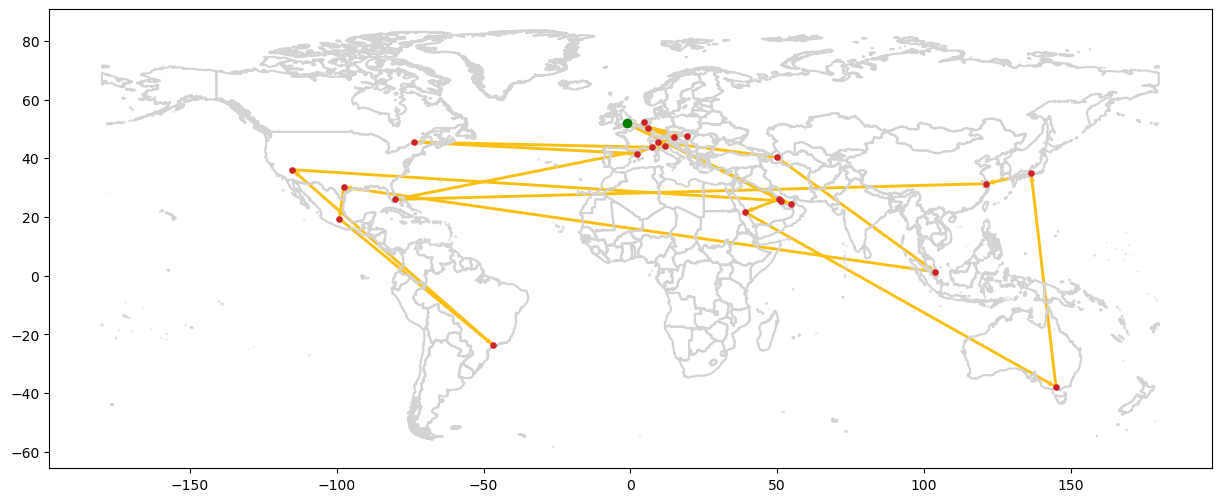

In [10]:
# Create a base map by plotting the world boundary with specified properties
base = world.boundary.plot(figsize=(15, 10), color="lightgrey", zorder=1, aspect="equal")
# Plot the locations from the 'loc' DataFrame on top of the base map in red
# Adjust the size of markers to 5, Ensure that the aspect ratio is equal
loc.plot(ax=base, color="red", markersize=5, aspect='equal')
# Plot the tour path on the same base map using the 'plot_path' function
# This function represents the tour with optional path markers or arrows
plot_path(loc, tour, ax=base)
# Plot the 'motorsport_valley' data on top of the base map in green , Ensure that the aspect ratio is equal
motorsport_valley.plot(ax=base, color="green", aspect="equal")


## 5. Performs a 2-opt optimisation using 1-opt starting point
#### All the relevant functions for 2-opt and 1-opt are as shown below:

In [11]:
## creates a tour that visits locations in a random order starting from a desired location
def zero_opt(C, rng=None, start=0):
    if rng is None:
        rng = np.random.defaut_rng()

    N = len(C)

    tour = np.arange(N)                         ## [ 0, 1, 2, ..., N - 3, N - 2, N - 1 ]    
    tour[0], tour[start] = tour[start], tour[0] ## shift the desired starting point to the first element of the tour
    rng.shuffle(tour[1:])                       ## note: rng.shuffle() shuffles the tour IN-PLACE! Also, note that we always start (and end) at location zero!
    return tour, tour_cost(C, tour)

In [12]:
def one_opt(C, start=0):
    N = len(C)
    tour = np.arange(N)                         ## [ 0, 1, 2, ..., N - 3, N - 2, N - 1 ]    
    tour[0], tour[start] = tour[start], tour[0] ## shift the desired starting point to the first element of the tour
    
    for i in range(N - 1):  ## while there are unvisited locations
        best = i + 1        ## remember the index of the next location with the lowest cost
        for j in range(i + 1, N): ## for all the currently unvisited locations
            if C[tour[i], tour[j]] < C[tour[i], tour[best]]:
                best = j
        tour[i + 1], tour[best] = tour[best], tour[i + 1] ## add the next closest location into the tour by swapping its position in the tour

    return tour, tour_cost(C, tour) ## return the tour and its associated cost

In [13]:
def two_opt(tour, C):
    tour = tour.copy()                                     ## make a copy, for no other reason than we may want to keep the original tour around as well
    best = tour_cost(C, tour)

    while True:                                            ## keep looping until no improvement can be made
        gain, start, end = find_improving_subtour(tour, C) ## extract the subtour that when reversed will produce the maximum gain
        if np.isclose(gain, 0):
            break                                          ## no improvement could be found, so quit the loop
        else:
            reverse_path(tour, start, end)                 ## we found a subtour that could be reversed to improve the total tour, so perform the reversal
            best -= gain

    return tour, best         

In [14]:
def compute_gain(C, tour, start, end):
    N = len(tour)
    gain = C[tour[start], tour[(start+1) % N]]         ## compute cost of adding edge between tour position i and (i + 1)
    gain += C[tour[end], tour[(end+1) % N]]            ## add cost of new edge between tour position j and (j + 1)
    gain -= C[tour[start], tour[end]]                  ## subtract cost of new edge between tour postions i and j
    gain -= C[tour[(start+1) % N], tour[(end+1) % N]]  ## subtract cost of new edge between tour positions (i + 1) and (j + 1)

    ## if gain is greater than zero, then the cost of the existing edges is greater than the cost of the new edges,
    ## therefore, reversing the subtour from start to end would be beneficial
    return gain

In [15]:
#This function reverse_path reverses a segment of a tour path between specified start and end indices.
def reverse_path(tour, start, end, inplace=True):
    
   
    # Parameters:
    # - tour: List or array representing the tour path.
    # - start: The starting index of the segment to be reversed.
    # - end: The ending index (inclusive) of the segment to be reversed.
    # - inplace: Boolean indicating whether to modify the 'tour' in-place (default is True).

    # Returns:
    # - X: A modified tour path with the specified segment reversed (if inplace=False).

    # Create a copy of the tour path if not modifying in-place
    if inplace:
        X = tour
    else:
        X = tour.copy()
    
    # Reverse the segment of the tour path between 'start' and 'end' indices
    X[(start + 1):(end + 1)] = np.flip(X[(start + 1):(end + 1)])
    
    # Return the modified tour path
    return X


In [16]:
#This function find_improving_subtour, finds an improving subtour within a given tour based on a cost matrix. And used for the two-opt search
def find_improving_subtour(tour, C):
    
    # Parameters:
    # - tour: List or array representing the current tour.
    # - C: Cost matrix representing distances between locations.

    # Returns:
    # - best_gain: The best improvement gain achievable by reversing a subtour.
    # - best_start: The starting index of the best improving subtour.
    # - best_end: The ending index of the best improving subtour.
   
    # Initialize variables to store the best gain and indices for the improving subtour
    best_gain, best_start, best_end = 0, -1, -1

    # Iterate through possible starting indices of the subtour
    for i in range(len(tour) - 2):
        # Iterate through possible ending indices of the subtour
        for j in range(i + 2, len(tour)):
            # Compute the gain (improvement) by reversing the subtour
            gain = compute_gain(C, tour, i, j)

            # Update the best gain and indices if the current gain is greater
            if gain > best_gain:
                best_gain, best_start, best_end = gain, i, j
    
    # Return the best improvement gain and the corresponding subtour indices
    return best_gain, best_start, best_end


In [17]:
def plot_tour(map, loc, tour):
    
    # Plot a tour on a given map along with location markers.

    # Parameters:
    # - map: A map or base layer to serve as the background.
    # - loc: DataFrame containing location data (nodes).
    # - tour: List or array representing the order of locations in the tour.

    # Returns:
    # - None, but it displays the map with the tour and location markers.

    # Create a new figure with a specified size
    fig = plt.figure(figsize=(16, 16))

    # Create an axes object for plotting within the figure
    ax = plt.axes()

    # Plot the map as a background layer with a specified color
    map.plot(ax=ax, zorder=-1, color='#00508F')

    # Plot the tour path on top of the map using the 'plot_path' function
    plot_path(loc, tour, ax=ax)

    # Display the plot
    plt.show()


### Cost of the 2-opt tour using 1-opt and the new optimised table

Using 2-opt, new best is 62642 kilometres


,Order
Location,
Silverstone Circuit,1
CM.com Circuit Zandvoort,2
Spa Francorchamps Grand Prix F1,3
Autodromo Nazionale Monza,4
Circuit de Barcelona-Catalunya,5
Monaco Grand Prix de Monaco,6
Autodromo Enzo e Dino Ferrari,7
Red Bull Ring,8
Hungaroring,9


<Axes: >

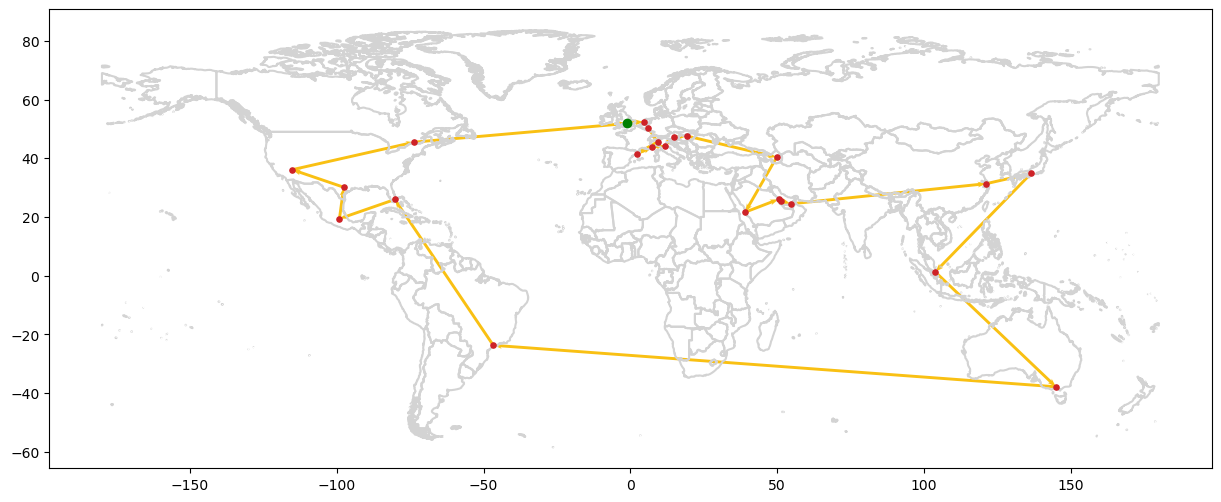

In [18]:
init_tour, init_cost = one_opt(C)
opt_tour, opt_cost = two_opt(init_tour, C)

# Create a Pandas DataFrame to store the tour information
optimised_calendar = pd.DataFrame({
    "Location": loc.loc[opt_tour]['Name'].values,
    "Order": range(0, len(opt_tour) )
})

# Remove "Motorsport Valley" from the optimized tour if it exists
if "Motorsport Valley" in optimised_calendar["Location"].values:
    optimised_calendar = optimised_calendar[optimised_calendar["Location"] != "Motorsport Valley"]
# Print the optimized tour and its cost
print(f"Using 2-opt, new best is {opt_cost/1000:.0f} kilometres")

# Set the 'Location' column as the index and drop the original index
optimised_calendar = optimised_calendar.set_index('Location', drop=True)

# Display the optimized tour without the index
display(optimised_calendar)

# Create a base map by plotting the world boundary with specified properties
base = world.boundary.plot(figsize=(15,10), color="lightgrey", zorder=1, aspect="equal")
# Plot the locations from the 'loc' DataFrame on top of the base map in red
# Adjust the size of markers to 5, Ensure that the aspect ratio is equal
loc.plot(ax=base, color="red", markersize=5, aspect="equal")
# Plot the tour path on the same base map using the 'plot_path' function
# This function represents the optimised tour with optional path markers or arrows
plot_path(loc, opt_tour, ax=base)
# Plot the 'motorsport_valley' data on top of the base map in green , Ensure that the aspect ratio is equal
motorsport_valley.plot(ax=base, color="green", aspect="equal")




I have added the Order column in the new optimised table, which shows the new order of the optimised circuits calendar. 
Also removed Motorsport Valley as it's irrelavent for optimising the circuit routes. Since Motorsport Valley is just the starting point.

#### The cost of using 2-opt using 1-opt initial being approximately 62,000km